In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../source/")
from fuzzy.fuzzyset import *
from fuzzy.operations import *
from fuzzy.control import *

In [2]:
def outside_temperature(start_temp, days=1):
    temps = []
    temp = start_temp
    for d in range(days):
        for time in range(6):
            temps.append(temp)
            temp -= 1

        for time in range(6,9):
            temps.append(temp)
            temp += 0.67

        for time in range(9,15):
            temps.append(temp)
            temp += 1.67

        for time in range(15, 18):
            temps.append(temp)
            temp += 0.33

        for time in range(18,24):
            temps.append(temp)
            temp -= 1.17


    return temps

In [3]:
def inhouse_temperature(in_t_prev, out_t_curr, control):
    in_t_curr = in_t_prev
    in_t_curr = (out_t_curr + in_t_prev)/2
    return in_t_curr + control

In [4]:
def error(temps):
    err = 0
    for i in temps:
        if i < 18:
            err += 18 - i
        elif i > 24:
            err += i - 24
    return err/len(temps)

In [5]:
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)

for t in range(1,24*5):
    in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))

(0.0, 36.0)

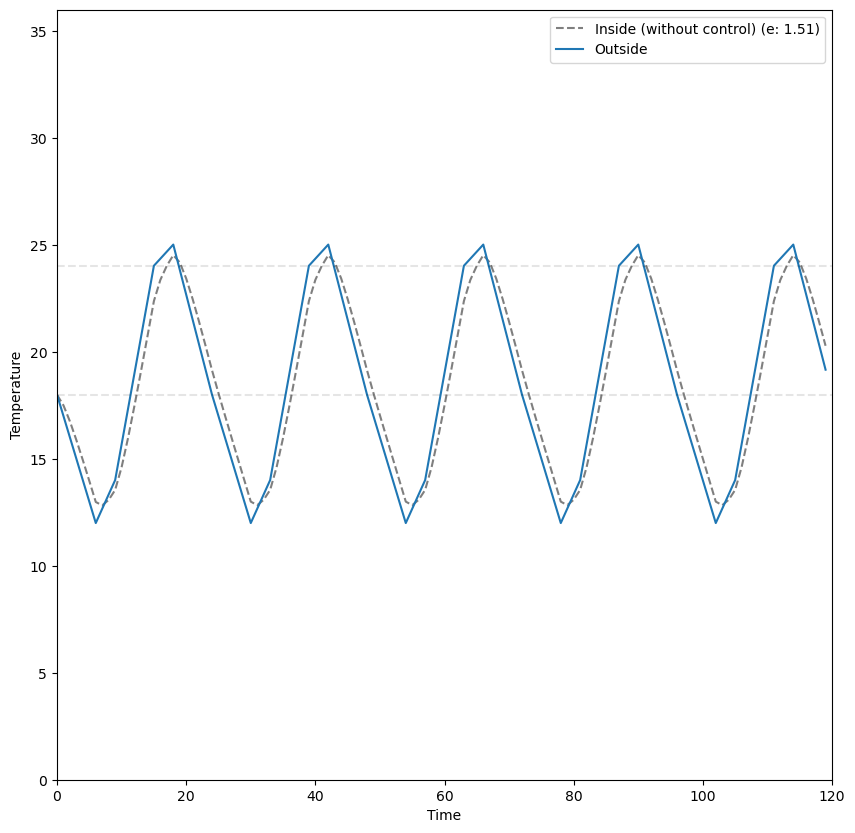

In [6]:
plt.figure(figsize=(10,10))

plt.plot(in_t_noc, label="Inside (without control) (e: %.2f)" % error(in_t_noc), c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(0,36)

In [7]:
t_low = RampFuzzyNumber(18, 12)
t_med = TrapezoidalFuzzyNumber(18, 20, 22, 24)
t_high = RampFuzzyNumber(26, 40)
c_lower = RampFuzzyNumber(-2,-1)
c_lowermed = TrapezoidalFuzzyNumber(-1.5, -1, -0.5, 0)
c_nochange = TriangularFuzzyNumber(-0.1, 0, 0.1)
c_highermed = TrapezoidalFuzzyNumber(0, 0.5, 1, 1.5)
c_higher = RampFuzzyNumber(1,2)

Text(0.5, 1.0, 'Temperature is low')

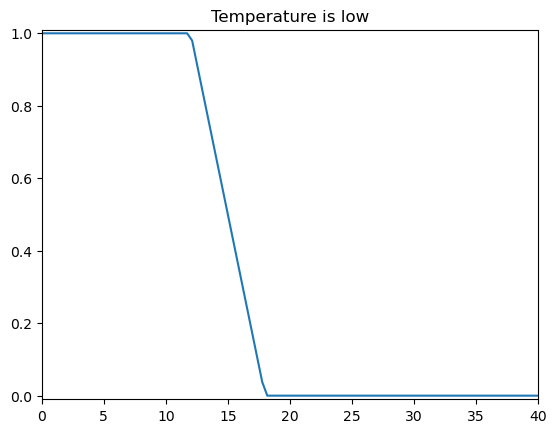

In [8]:
xs = np.linspace(0, 40, 100)
ys = [t_low(v) for v in xs]
plt.plot(xs, ys)
plt.xlim(0,40)
plt.ylim(-0.01,1.01)
plt.title("Temperature is low")

Text(0.5, 1.0, 'Temperature is medium')

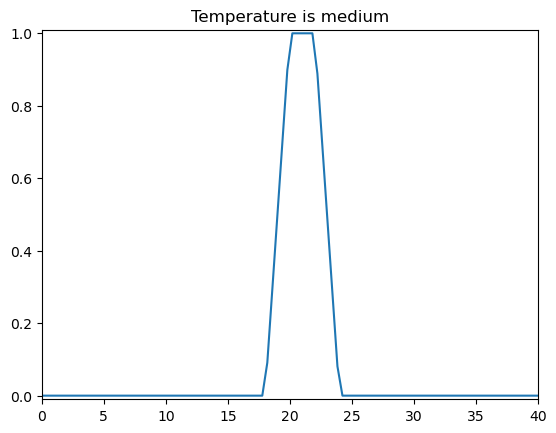

In [9]:
xs = np.linspace(0, 40, 100)
ys = [t_med(v) for v in xs]
plt.plot(xs, ys)
plt.xlim(0,40)
plt.ylim(-0.01,1.01)
plt.title("Temperature is medium")

Text(0.5, 1.0, 'Temperature is high')

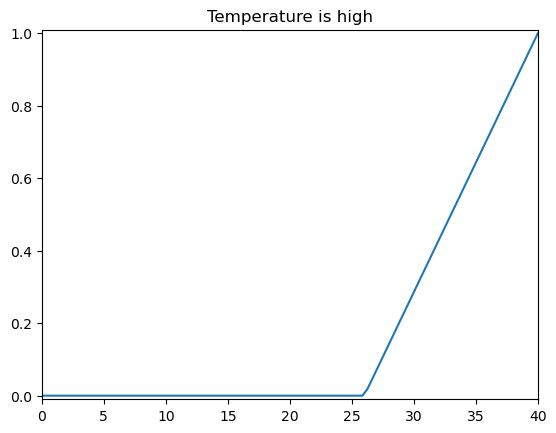

In [10]:
xs = np.linspace(0, 40, 100)
ys = [t_high(v) for v in xs]
plt.plot(xs, ys)
plt.xlim(0,40)
plt.ylim(-0.01,1.01)
plt.title("Temperature is high")

In [11]:
rule_low = MamdaniRule({"temp": t_low}, "c", c_higher, minimum)
rule_lowmed = MamdaniRule({"temp": t_low, "temp": t_med}, "c", c_highermed, minimum)
rule_medium = MamdaniRule({"temp": t_med}, "c", c_nochange, minimum)
rule_highmed = MamdaniRule({"temp": t_med, "temp": t_high}, "c", c_lowermed, minimum)
rule_high = MamdaniRule({"temp": t_high}, "c", c_lower, minimum)

control = FuzzyControlSystem([rule_low, rule_lowmed, rule_medium, rule_highmed, rule_high], tconorm=maximum)

In [12]:
in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)

for t in range(1,24*5):
    cnt = control.evaluate({"temp": in_t[t-1]})["c"]
    in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt))
    in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))

(0.0, 36.0)

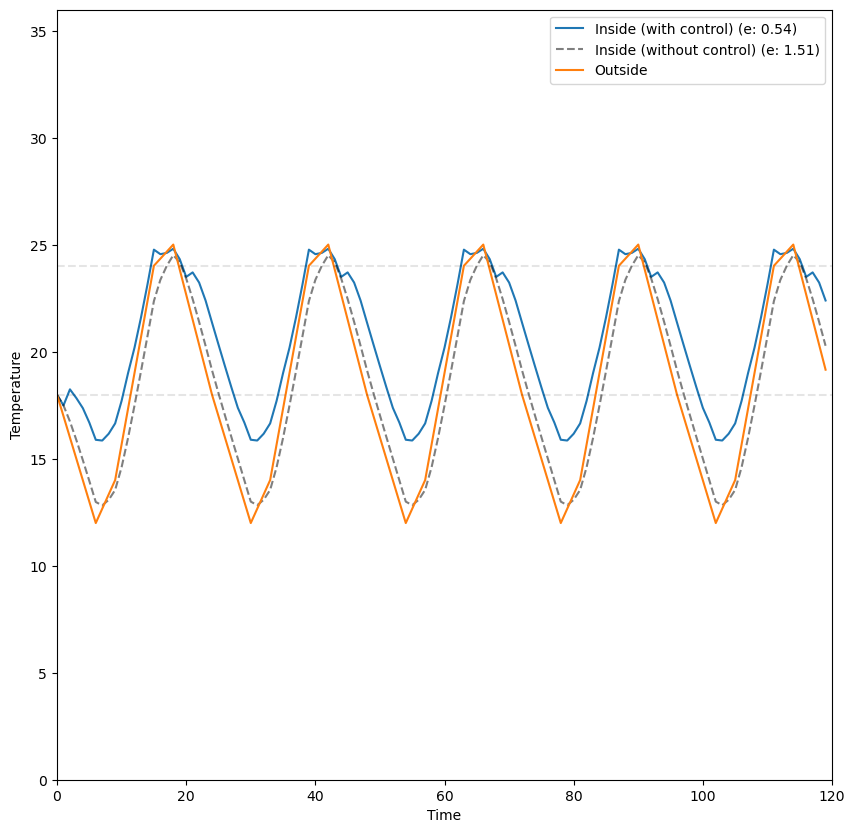

In [13]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control) (e: %.2f)" % error(in_t))
plt.plot(in_t_noc, label="Inside (without control) (e: %.2f)" % error(in_t_noc), c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(0,36)

In [14]:
t_low = RampFuzzyNumber(18, 12)
t_med = TrapezoidalFuzzyNumber(16, 18, 24, 26)
t_high = RampFuzzyNumber(26, 40)

def control_low(params):
    return (18 - params["temp"])/(18 - 15) 

def control_med(params):
    return (24 - params["temp"])/(24 - 18)

def control_high(params):
    return (24 - params["temp"])/(24 - 27)

In [15]:
rule_l = SugenoRule({"temp": t_low}, "c", control_low, minimum)
rule_m = SugenoRule({"temp": t_med}, "c", control_med, minimum)
rule_h = SugenoRule({"temp": t_high}, "c", control_high, minimum)

control = FuzzyControlSystem([rule_l, rule_m, rule_h], tconorm=maximum, type=SugenoRule)

In [16]:
in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)

for t in range(1,24*5):
    cnt = control.evaluate({"temp": in_t[t-1]})["c"]
    in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt))
    in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))

(0.0, 36.0)

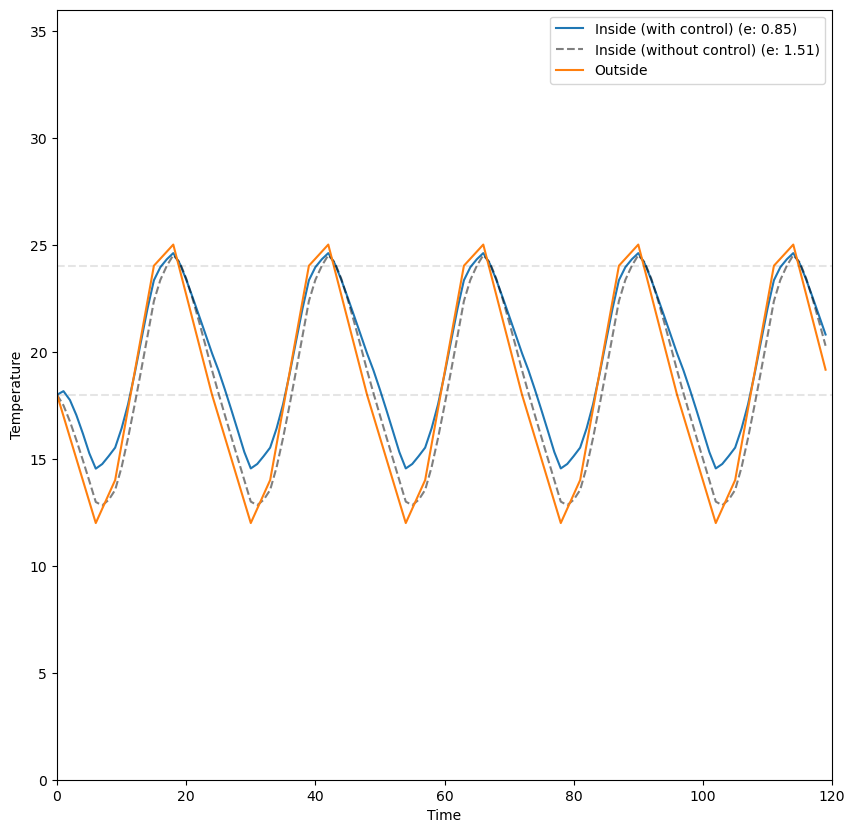

In [17]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control) (e: %.2f)" % error(in_t))
plt.plot(in_t_noc, label="Inside (without control) (e: %.2f)" % error(in_t_noc), c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(0,36)